In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import pandas as pd
from pandas.api.types import CategoricalDtype
import scipy as sp
from pathlib import Path
import tkinter as tk
from tkinter import filedialog
import itertools
from colour import Color
from datetime import date
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MaxNLocator
from scipy import stats
from read_roi import read_roi_zip
from collections import OrderedDict, Counter
import math
import PIL
from PIL import Image
from PIL.TiffTags import TAGS

In [2]:
today = date.today()
print("Today's date:", today)
date = str(today)
date

Today's date: 2023-06-07


'2023-06-07'

In [3]:
tubulin = '[Tubulin] ' r'$(\mu M)$'
tub = 'tub'

DCXconc = '[DCX] ' r'$(n M)$'
EBconc = '[EB] ' r'$(n M)$'
DCX = 'DCX'
Type = 'DCX Type'

Concentration = 'Concentration ' r'$(\mu M)$'
Length = 'Length ' r'$(\mu m)$'
Lifetime = 'Lifetime ' r'$(min)$'
GrowthRate = 'Growth Rate ' r'$(\mu m / min)$'
TimeToNucleate = 'Time to Nucleate ' r'$(min)$'
ShrinkageLength = 'Shrink Length ' r'$(\mu m)$'
ShrinkageLifetime = 'Shrink Lifetime ' r'$(min)$'
ShrinkageRate = 'Shrink Rate ' r'$(\mu m / min)$'

In [4]:
black = '#000000'
grey = '#777777'
peri = '#6666FF'
darkperi = '#33FFFF'
lightperi = '#9999FF'
blue = '#23459C'
green = '#79BA1A'
purple = '#AB4A9C'
lily = '#CB81EA'
magenta = '#D80B8C'
red = '#e60000'
orange = '#FF7300'
darkorange = '#FF5B00'
lightorange = '#FFAC83'
yellow = '#FFCB05'
lightyellow = '#F9DC2D'
pink = '#FFA4CD'
StartHue1 = Color(pink)
DC1color = list(StartHue1.range_to(Color(darkorange),3))
StartHue2 = Color(darkorange)
DC2color = list(StartHue2.range_to(Color(lightorange),3))
print(DC1color,DC2color)

palette = [magenta] + list(map(Color.get_hex,DC1color)) + list(map(Color.get_hex,DC2color)) + [green,purple]
# palette = [grey,cyan]
parameters = [GrowthRate,TimeToNucleate,Lifetime,ShrinkageRate]

[<Color #ffa4cd>, <Color #52fff7>, <Color #ff5b00>] [<Color #ff5b00>, <Color #ff8341>, <Color #ffac83>]


In [5]:
askmastersheet = filedialog.askopenfilename() # show an "Open" dialog box and return the path to the selected file
data = pd.read_csv(askmastersheet, encoding='utf-8')
data

,Date,Investigator,Ch,[Tubulin] $(\mu M)$,[DCX] $(n M)$,[EB] $(n M)$,Length $(\mu m)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Time to Nucleate $(min)$,Shrink Length $(\mu m)$,Shrink Lifetime $(min)$,Shrink Rate $(\mu m / min)$,Rescues,DCX Type
0,2022-12-19,Brandi,1,6,0,0,0.695500,5.898500,0.117911,5.424389,1.070000,0.251000,4.262948,False,None
1,2022-12-19,Brandi,1,6,0,0,0.856000,6.275000,0.136414,18.769222,1.070000,0.251000,4.262948,False,None
2,2022-12-19,Brandi,1,6,0,0,0.856000,2.761000,0.310033,6.804889,0.856000,0.167333,5.115538,False,None
3,2022-12-19,Brandi,1,6,0,0,1.070000,2.677333,0.399651,3.374556,1.070000,0.167333,6.394422,False,None
4,2022-12-19,Brandi,1,6,0,0,0.749000,2.259000,0.331563,10.486222,0.856000,0.083667,10.231076,False,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2041,2023-05-16,Brandi,4,8,0,20,1.230500,1.422333,0.865128,3.332722,1.391000,0.083667,16.625498,False,None
2042,2023-05-16,Brandi,4,8,0,20,1.391000,1.589667,0.875026,2.621556,1.391000,0.083667,16.625498,False,None
2043,2023-05-16,Brandi,4,8,0,20,2.354000,2.217167,1.061715,6.679389,2.461000,0.083667,29.414343,False,None
2044,2023-05-16,Brandi,4,8,0,20,2.068667,2.398445,0.862503,3.346667,2.354000,0.055778,42.203349,False,None


In [6]:
pathmastersheet = Path(askmastersheet)
resultdirectory = str(pathmastersheet.parents[0])+'//Stats'
newmydir = Path(resultdirectory)
newmydir.mkdir(exist_ok=True)
path = newmydir
path

WindowsPath('C:/Users/Brouhard Lab/Data/Results_Files/DCX_EB_Dynamics/IRM/Master/Stats')

In [7]:
dfr='Replicates'
dfr=data.groupby('Expt', as_index=False).count()
#dfm.rename(columns={GrowthRate:GRmn}, inplace=True)
dfr

KeyError: 'Expt'

In [77]:
dfm='Mean'
dfm=data.groupby('Expt', as_index=False).mean()
#dfm.rename(columns={GrowthRate:GRmn}, inplace=True)
dfm

,Expt,Ch,[Tubulin] $(\mu M)$,[DCX] $(n M)$,[EB] $(n M)$,Length $(\mu m)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Time to Nucleate $(min)$,Rescues
0,EB3,2.860759,8.0,0.0,20.0,1.678478,1.781182,0.979310,5.112073,0.009494
1,P191R,1.000000,8.0,60.0,0.0,7.986786,12.251190,0.649190,1.160875,0.178571
2,P191R+EB3,3.000000,8.0,60.0,20.0,1.223752,1.246332,1.022858,6.968265,0.000000
3,Tubulin,1.080808,8.0,0.0,0.0,4.970456,8.113648,0.614678,3.383711,0.053872
4,WT,2.840659,8.0,60.0,0.0,8.702471,10.781661,0.803146,1.403524,0.104396
5,WT+EB,2.631579,8.0,60.0,20.0,2.063387,1.852730,1.171573,3.747982,0.006579


In [80]:
dfs='Stdev'
dfs=data.groupby('Expt', as_index=False).std()
dfm.rename(columns={GrowthRate:dfs}, inplace=True)
dfs

,Expt,Ch,[Tubulin] $(\mu M)$,[DCX] $(n M)$,[EB] $(n M)$,Length $(\mu m)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Time to Nucleate $(min)$,Rescues
0,EB3,0.843036,0.0,0.0,0.0,1.025012,1.158323,0.209801,5.859862,0.097126
1,P191R,0.000000,0.0,0.0,0.0,4.350259,6.392541,0.115014,0.942513,0.386459
2,P191R+EB3,0.000000,0.0,0.0,0.0,0.466347,0.560821,0.193195,7.117826,0.000000
3,Tubulin,0.273000,0.0,0.0,0.0,3.761155,5.427295,0.172742,3.844701,0.226146
4,WT,0.367003,0.0,0.0,0.0,5.398177,6.226989,0.151897,2.604994,0.306617
5,WT+EB,1.216249,0.0,0.0,0.0,1.479033,1.411596,0.246682,5.387499,0.081111


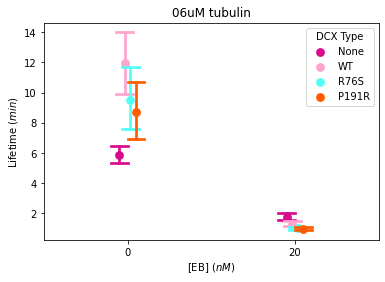

In [7]:
sns.pointplot(x=EBconc, y=Lifetime,
                         hue=Type, dodge=True,
                      err_style="bars", marker='o', join=False, capsize=.1,
                        data=data[(data[tubulin]==6)],err_kws={'capsize':10},ci=95 , palette=palette).set(title='06uM tubulin')
plt.savefig(path/('tub6uM_Lifetime_ALL'+date+'.svg'))

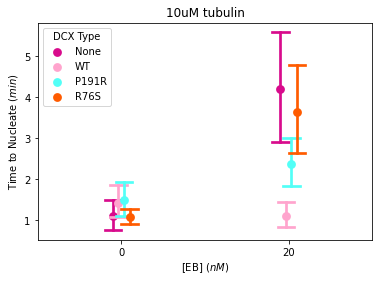

In [8]:
sns.pointplot(x=EBconc, y=TimeToNucleate,
                         hue=Type, dodge=True,
                      err_style="bars", marker='o', join=False, capsize=.1,
                        data=data[(data[tubulin]==10)],err_kws={'capsize':10},ci=95 , palette=palette).set(title='10uM tubulin')
plt.savefig(path/('tub10uM_nucleation_ALL'+date+'.svg'))

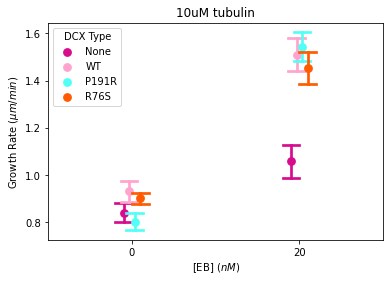

In [9]:
sns.pointplot(x=EBconc, y=GrowthRate,
                         hue=Type, dodge=True,
                      err_style="bars", marker='o', join=False, capsize=.1,
                        data=data[(data[tubulin]==10)],err_kws={'capsize':10},ci=95 , palette=palette).set(title='10uM tubulin')
plt.savefig(path/('tub10uM_GR_ALL'+date+'.svg'))

In [ ]:
stats.ttest_ind(dataf2['TOTAL_DISTANCE_TRAVELED (um)'][dataf2['GENOTYPE'] == 'CTRL0'],
                dataf2['TOTAL_DISTANCE_TRAVELED (um)'][dataf2['GENOTYPE'] == 'DCXKO1'])